In [1]:
import os
from datetime import datetime
#from datetime import date``
import pymysql
from sqlalchemy import create_engine, text
from decouple import config 
from dotenv import load_dotenv
import pandas as pd
from numpy import int16
from enum import Enum
from dataframe_image import export
from datetime import datetime

In [2]:
# Using enum class create enumerations
class Constante(Enum):
   glob = ""
   specific = "2023-06-01"
   end = datetime.today().strftime("%Y-%m-%d")

In [3]:
load_dotenv()
# get the environment variables needed
USER= config('USRCaris')
PASSWORD= config('PASSCaris')
HOSTNAME= config('HOSTCaris')
DBNAME= config('DBCaris')
# get the engine to connect and fetch
engine = create_engine(f"mysql+pymysql://{USER}:{PASSWORD}@{HOSTNAME}/{DBNAME}")
query = f'''
    SELECT 
    agent_username, COUNT(*) AS nbre,
    dsd.organisation,
    dsd.timeEnd as entry_date
FROM
    caris_db.dreams_surveys_data dsd
WHERE
    dsd.timeEnd >= '{Constante.specific.value}'
    and
    dsd.timeEnd <= '{Constante.end.value}'
GROUP BY agent_username
'''
agent = pd.read_sql_query(text(query),engine.connect(),parse_dates=True)
# get the test excel file from Query
# close the pool of connection
engine.dispose()

## Agent DREAMS sortant du Systeme

In [4]:
agent.rename(columns={'agent_username':'username'},inplace=True)

In [5]:
agent

,username,nbre,organisation,entry_date
0,1annuelle,10,Caris,2023-06-01 23:06:09
1,1chrislyne,43,Caris,2023-06-20 16:12:53
2,1dialine,29,Caris,2023-08-30 17:17:30
3,1louis,21,Caris,2023-06-08 19:10:02
4,1victor,67,Caris,2023-06-19 18:19:57
5,2billy,120,Caris,2023-09-01 16:09:05
6,2diegoarmando,143,Caris,2023-07-06 14:30:47
7,2eliona,54,Caris,2023-08-26 23:52:07
8,2ernst,188,Caris,2023-06-14 15:21:08
9,2fabrice,121,Caris,2023-06-14 15:04:35


In [6]:
agent_name = pd.read_excel("caris-test_users_28d6565d382d48b4b97c742c6a7872e0.xlsx")
agent_past_data = pd.read_excel("performance_formulaire_denrolement.xlsx")

In [7]:
agent_name = agent_name[["username","name"]]

## Liste de tous les agents avec Leur nom

In [8]:
agent_name

,username,name
0,1aldonzar,elcie aldonzar
1,1alexandra,Alexandra Joseph
2,1annuelle,Annuelle Eustache
3,1cadet,Memie Cadet
4,1claudius,Claudius Gladys
...,...,...
761,s2julnor,Julnor Beaubrun
762,s2mirlene,Vernet Mirlene
763,stfleur,Jesula St Fleur
764,sylvietest,sylvie rousseau


In [9]:
agent_name = agent_name.merge(agent,on="username",how="inner")

In [10]:
agent_name.sort_values(by=['nbre'],ascending=False,inplace=True)

In [11]:
agent_name

,username,name,nbre,organisation,entry_date
7,2gerald,Gerald Poteau,292,Caris,2023-07-20 15:28:35
15,6reline,Reline Augustin,243,Caris,2023-06-07 00:27:43
5,2ernst,Ernst Belabre,188,Caris,2023-06-14 15:21:08
3,2diegoarmando,Diego Armando Dorlean,143,Caris,2023-07-06 14:30:47
6,2fabrice,Fabrice Byron,121,Caris,2023-06-14 15:04:35
2,2billy,Billy jolicoeur,120,Caris,2023-09-01 16:09:05
13,6jesumene,Jesumène Jean-Louis,106,Caris,2023-08-06 12:08:13
11,6chelot,Chelot Demosthene,101,Caris,2023-06-30 23:00:58
12,6frazyouseline,Fraz-Youseline Dorcent,74,Caris,2023-09-03 02:10:05
14,6kettelande,Kettelande Benjamin,59,Caris,2023-06-23 13:25:44


In [12]:
agent_past_data = agent_past_data[["username","nbre"]]

In [13]:
agent_past_data.rename(columns={'nbre':'past_entry'},inplace=True)

In [14]:
agent_name = agent_name.merge(agent_past_data,on="username",how="left")
agent_name.fillna(0,inplace=True)

In [15]:
agent_name['nbre_new_entry'] = agent_name['nbre'] - agent_name['past_entry']

In [16]:
agent_name

,username,name,nbre,organisation,entry_date,past_entry,nbre_new_entry
0,2gerald,Gerald Poteau,292,Caris,2023-07-20 15:28:35,292.0,0.0
1,6reline,Reline Augustin,243,Caris,2023-06-07 00:27:43,243.0,0.0
2,2ernst,Ernst Belabre,188,Caris,2023-06-14 15:21:08,188.0,0.0
3,2diegoarmando,Diego Armando Dorlean,143,Caris,2023-07-06 14:30:47,143.0,0.0
4,2fabrice,Fabrice Byron,121,Caris,2023-06-14 15:04:35,91.0,30.0
5,2billy,Billy jolicoeur,120,Caris,2023-09-01 16:09:05,71.0,49.0
6,6jesumene,Jesumène Jean-Louis,106,Caris,2023-08-06 12:08:13,62.0,44.0
7,6chelot,Chelot Demosthene,101,Caris,2023-06-30 23:00:58,101.0,0.0
8,6frazyouseline,Fraz-Youseline Dorcent,74,Caris,2023-09-03 02:10:05,0.0,74.0
9,6kettelande,Kettelande Benjamin,59,Caris,2023-06-23 13:25:44,59.0,0.0


In [17]:
agent_name = agent_name[['username','name','nbre','nbre_new_entry','organisation','entry_date']]

In [18]:
agent_name.nbre_new_entry = agent_name.nbre_new_entry.astype(int)

/var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/ipykernel_19630/3945026564.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agent_name.nbre_new_entry = agent_name.nbre_new_entry.astype(int)


In [19]:
agent_name

,username,name,nbre,nbre_new_entry,organisation,entry_date
0,2gerald,Gerald Poteau,292,0,Caris,2023-07-20 15:28:35
1,6reline,Reline Augustin,243,0,Caris,2023-06-07 00:27:43
2,2ernst,Ernst Belabre,188,0,Caris,2023-06-14 15:21:08
3,2diegoarmando,Diego Armando Dorlean,143,0,Caris,2023-07-06 14:30:47
4,2fabrice,Fabrice Byron,121,30,Caris,2023-06-14 15:04:35
5,2billy,Billy jolicoeur,120,49,Caris,2023-09-01 16:09:05
6,6jesumene,Jesumène Jean-Louis,106,44,Caris,2023-08-06 12:08:13
7,6chelot,Chelot Demosthene,101,0,Caris,2023-06-30 23:00:58
8,6frazyouseline,Fraz-Youseline Dorcent,74,74,Caris,2023-09-03 02:10:05
9,6kettelande,Kettelande Benjamin,59,0,Caris,2023-06-23 13:25:44


## MERGE (Vlookup)

In [20]:
performanceAgents = agent_name

In [21]:
performanceAgents.nbre.sum()

1675

In [22]:
performanceAgents

,username,name,nbre,nbre_new_entry,organisation,entry_date
0,2gerald,Gerald Poteau,292,0,Caris,2023-07-20 15:28:35
1,6reline,Reline Augustin,243,0,Caris,2023-06-07 00:27:43
2,2ernst,Ernst Belabre,188,0,Caris,2023-06-14 15:21:08
3,2diegoarmando,Diego Armando Dorlean,143,0,Caris,2023-07-06 14:30:47
4,2fabrice,Fabrice Byron,121,30,Caris,2023-06-14 15:04:35
5,2billy,Billy jolicoeur,120,49,Caris,2023-09-01 16:09:05
6,6jesumene,Jesumène Jean-Louis,106,44,Caris,2023-08-06 12:08:13
7,6chelot,Chelot Demosthene,101,0,Caris,2023-06-30 23:00:58
8,6frazyouseline,Fraz-Youseline Dorcent,74,74,Caris,2023-09-03 02:10:05
9,6kettelande,Kettelande Benjamin,59,0,Caris,2023-06-23 13:25:44


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [24]:
from datetime import datetime
date_du_jour = datetime.today().strftime("%d_%m_%Y")

In [25]:
orderdata = performanceAgents.nbre.sort_values().to_list()

/var/folders/7v/rs0k237d6nj3vdxfc1h7xtcw0000gn/T/ipykernel_19630/3559788714.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)


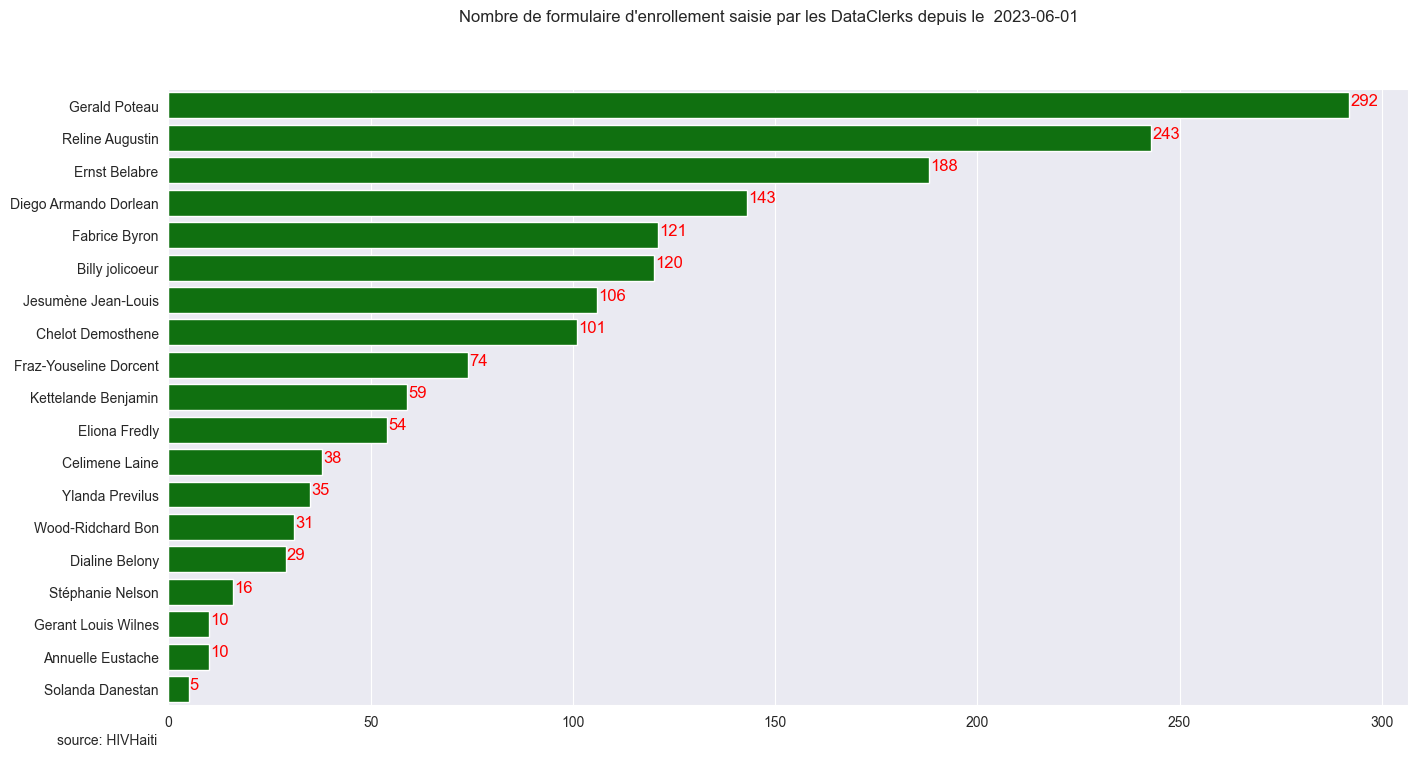

In [26]:
try:
    plt.figure(figsize=(16,8))
    #plt.subplots(figsize=(16,8))
    sns.set_style("darkgrid")
    splot = sns.barplot(x="nbre",y="name",data=performanceAgents,color="Green",order=performanceAgents.sort_values("nbre",ascending=False).name,ci=False)
    splot.set_xlabel("")
    splot.set_ylabel("")
    plt.suptitle(f"Nombre de formulaire d'enrollement saisie par les DataClerks depuis le  {Constante.specific.value}")
    for p in splot.patches:
        width = p.get_width()
        plt.text(0.25+p.get_width(), p.get_y()+0.50*p.get_height(),
                '{:1.0f}'.format(width),fontdict=dict(color="red",fontsize=12))

    plt.annotate(
        "source: HIVHaiti",(0,0), (-80,-20), fontsize=10, 
                xycoords='axes fraction', textcoords='offset points', va='top'
    )

    #plt.savefig(f"saisie_screening_{date_du_jour}",dpi=1000)
except ValueError:
    print("No data is avalaible")

In [27]:
performanceAgents.nbre.sum()


1675

In [28]:
performanceAgents.nbre_new_entry.sum()

266

In [29]:
performanceAgents.to_excel(f"performance_formulaire_denrolement.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_{date_du_jour}.xlsx",index=False,na_rep="NULL")
#performanceAgents.to_excel(f"performance_formulaire_denrolement_depuis_1Mars2021.xlsx",index=False,na_rep="NULL")